# **EXTIMATING THE AGE OF PEOPLE FROM VOCAL RECORDINGS**
BELLO RENATO and CHIODO MARTINA

In [35]:
# importing the modules we will nedd --> TOGLIERE QUELLE SUPERFLUE!!!!!!!!!!
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from modules.extract_feature import new_csv_with_audio_extracted_features

## **EXTRACTION OF SIGNIFICATIVE FEATURES FROM THE RECORDINGS**

In [38]:
# For convenience, we decided to write new csv containing all the features contained in the given dataset plus the features extracted by the audio recordings 
num_segm = 20
new_csv_with_audio_extracted_features(num_segmentation=num_segm)

datasets/audios_development/1.wav
datasets/audios_development/2.wav
datasets/audios_development/3.wav
datasets/audios_development/4.wav
datasets/audios_development/5.wav
datasets/audios_development/6.wav
datasets/audios_development/7.wav
datasets/audios_development/8.wav
datasets/audios_development/9.wav
datasets/audios_development/10.wav
datasets/audios_development/11.wav
datasets/audios_development/12.wav
datasets/audios_development/13.wav
datasets/audios_development/14.wav
datasets/audios_development/15.wav
datasets/audios_development/16.wav
datasets/audios_development/17.wav
datasets/audios_development/18.wav
datasets/audios_development/19.wav
datasets/audios_development/20.wav
datasets/audios_development/21.wav
datasets/audios_development/22.wav
datasets/audios_development/23.wav
datasets/audios_development/24.wav
datasets/audios_development/25.wav
datasets/audios_development/26.wav
datasets/audios_development/27.wav
datasets/audios_development/28.wav
datasets/audios_development/2

## **DATA EXPLORATION**

In [62]:
# Loading the datasets from the previously csv created
data_dev = pd.read_csv(f'datasets/development_features_{num_segm}.csv')
data_eval = pd.read_csv(f'datasets/evaluation_features_{num_segm}.csv')
df = pd.read_csv(f'datasets/development.csv')

# We can perform some data exploration, for convenience we are going to look only at the ones given in the initial datasets
labels = list(df.columns.values)
labels.remove('ethnicity')
labels.remove('path')
labels.remove('Id')
labels.remove('gender')
labels.append('gender_male')
labels.append('gender_female')


In [50]:
# Do we have any missin values?
null_values_dev = data_dev.isnull().sum()
null_values_eval = data_eval.isnull().sum()
print("Count total NaN at each column in data_dev : \n", null_values_dev) 
print("Count total NaN at each column in data_eval : \n", null_values_eval) 

Count total NaN at each column in data_dev : 
 Id               0
sampling_rate    0
age              0
mean_pitch       0
max_pitch        0
                ..
mfcc_6           0
mfcc_7           0
mfcc_8           0
mfcc_9           0
mfcc_10          0
Length: 235, dtype: int64
Count total NaN at each column in data_eval : 
 Id               0
sampling_rate    0
mean_pitch       0
max_pitch        0
min_pitch        0
                ..
mfcc_6           0
mfcc_7           0
mfcc_8           0
mfcc_9           0
mfcc_10          0
Length: 234, dtype: int64


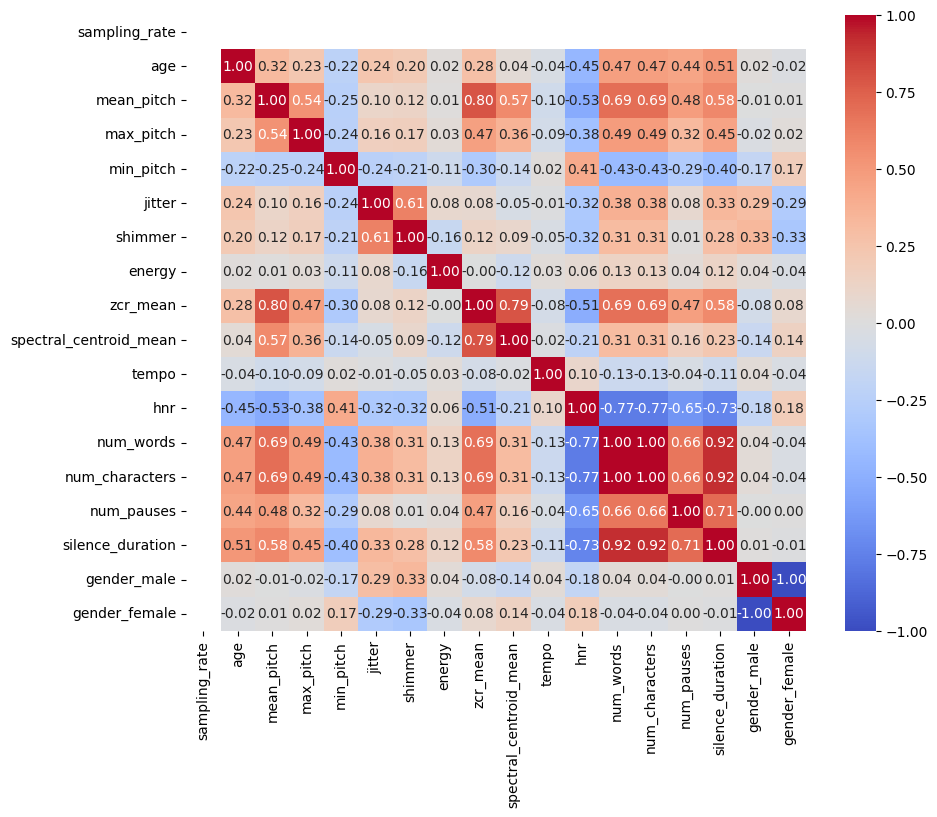

In [54]:
# We can look at the correlation between features
correlation_matrix = data_dev[labels].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

From this correlation graph, we can see that num_words and num_characters have the maximum value that the correlation can assume. Thus we are keeping just one of these features to avoid rendundance.

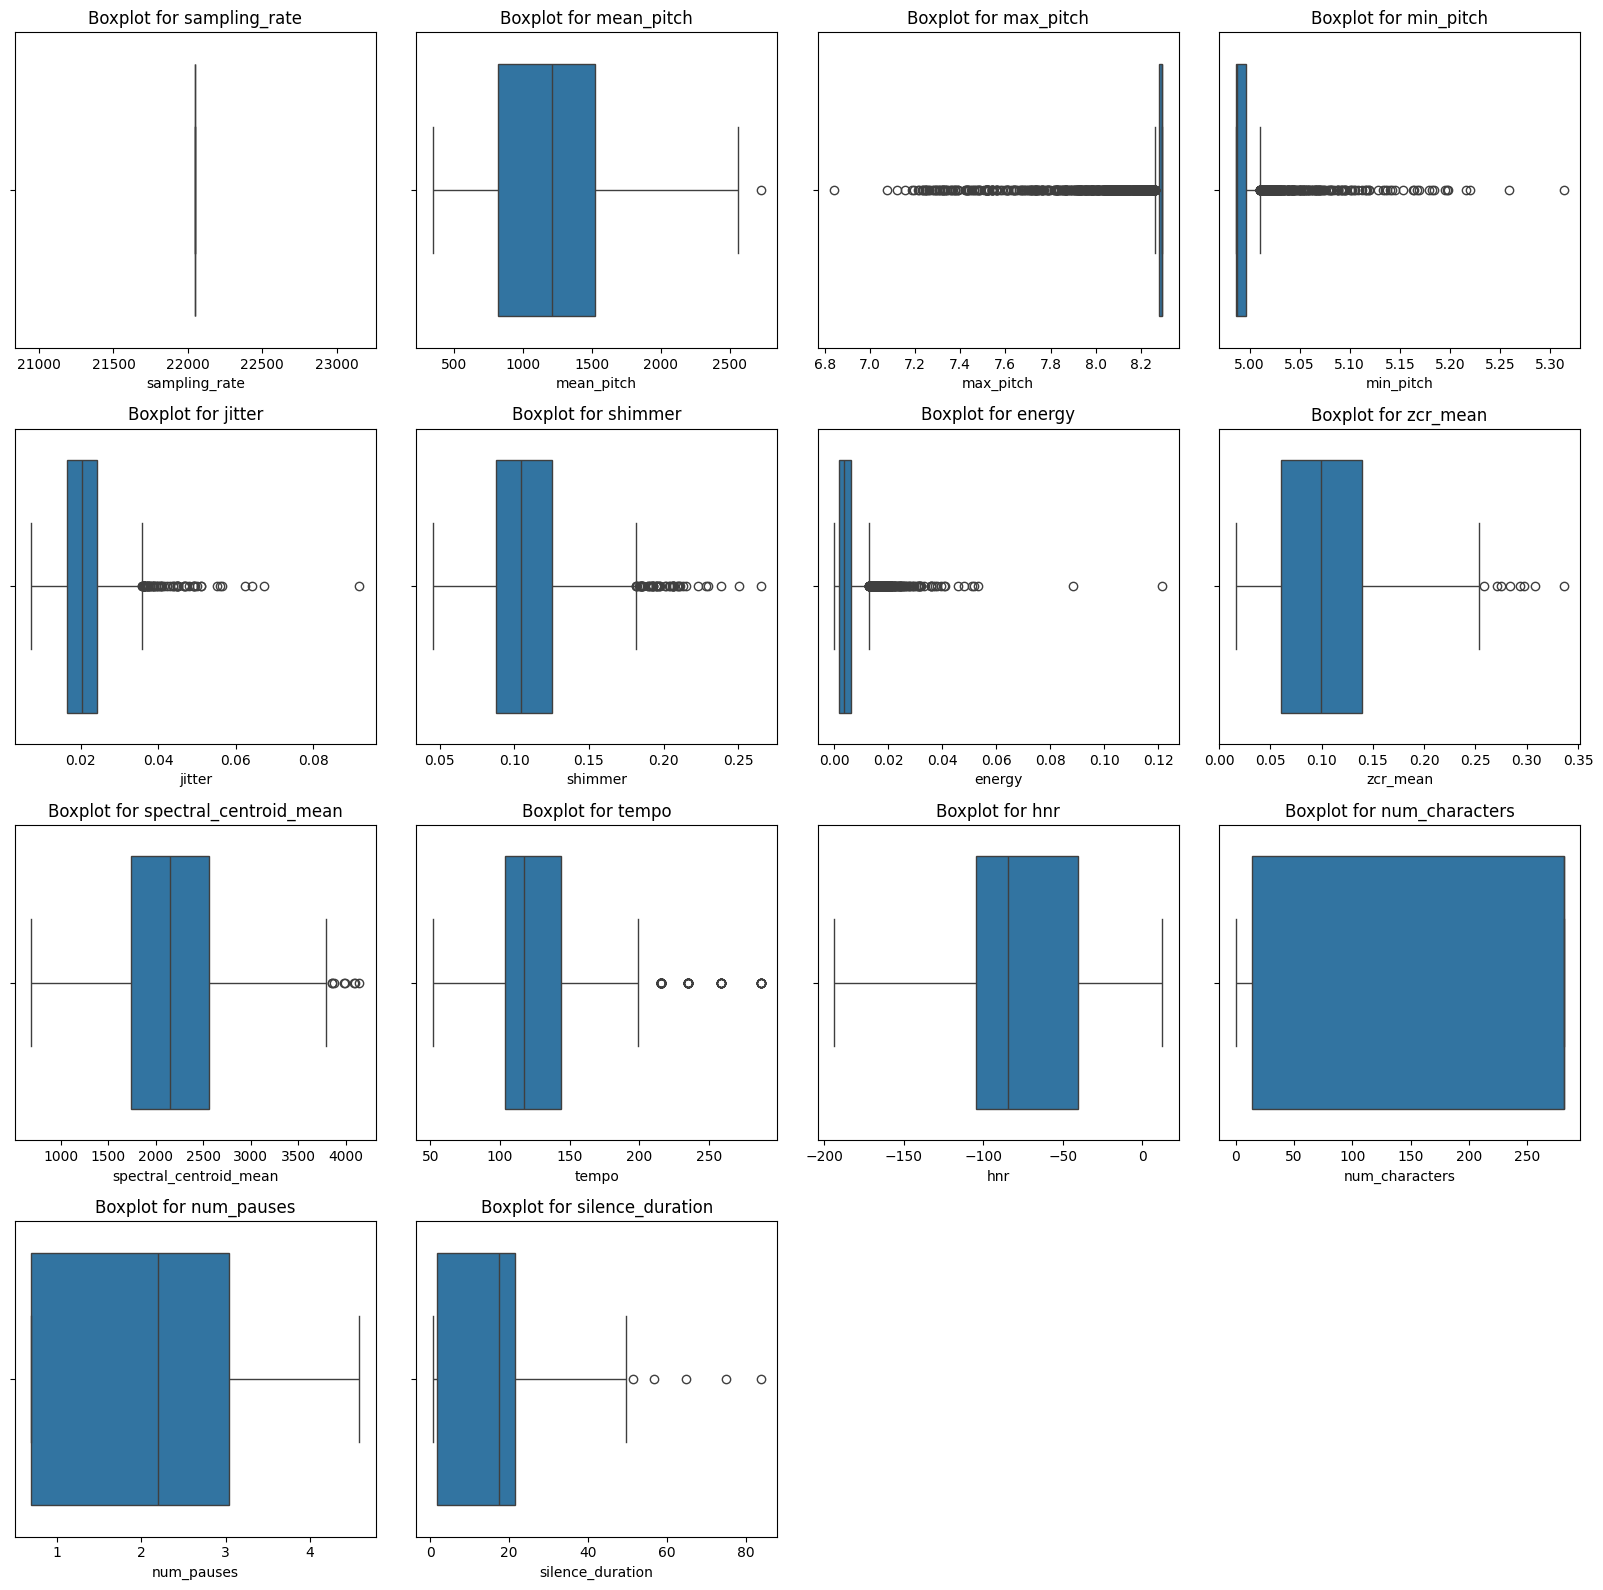

In [ ]:
Xdata_dev = data_dev.drop(columns=['path', 'Id', 'age', 'num_words'])
ydata_dev = data_dev['age']
Xdata_eval = data_eval.drop(columns=['path', 'num_words'])

# Some boxplots to look at the distribution of the numerical features, for some features we are going to apply a log transformation
# Boxplots can be helpful to detect outliers
copy_dev = Xdata_dev.copy()
copy_eval = Xdata_eval.copy()

numerical_columns = labels.copy()
numerical_columns.remove('age')
numerical_columns.remove('num_words')
numerical_columns.remove('gender_female')
numerical_columns.remove('gender_male')


for col in ['num_pauses',  'energy', 'jitter', 'min_pitch', 'max_pitch']:
    copy_dev[col] = np.log1p(copy_dev[col])
    copy_eval[col] = np.log1p(copy_eval[col])
  

# Displaying 4 boxplots for row
cols_per_row = 4
rows = (len(numerical_columns) + cols_per_row - 1) // cols_per_row
# Create a grid of boxplots using seaborn
fig, axes = plt.subplots(rows, cols_per_row, figsize=(16, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.boxplot(x=copy_dev[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')
    axes[i].set_xlabel(column)

for i in range(len(numerical_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## **PREPROCESSING**

In [68]:
# Dividing the dataset into development and validation
X_train, X_validation, y_train, y_validation = train_test_split(copy_dev, ydata_dev, test_size=0.2, random_state=42)


# We decided to standardize the datasets using a standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)

## **MODELS**

In this section we will compare the performances of two regressors to decide the one which performs better. 
Before training the regressor, we are going to apply an RFE in order to extract a subset of features that better explains the data in order to avoid overfitting due to the usage of many features and to avoid an excessive computational cost while fitting the regression.
For both regressor we are going to perform a GridSearch to find the best hyper-parameters of the regressor.
In order to evaluate the performances of the regressors we are going to use the root mean squared error (RMSE).

## **PREVISION**

In [ ]:
# Now that we have decided the model to use, we can predict the age of the speakers based on the information contained in the evaluation set.
model_pred = ...

# Preprocessing --> standardization of the datasets
scaler_pred = StandardScaler()
scaler_pred.fit(copy_dev)
Xdev_scaled = scaler_pred.transform(copy_dev)
Xdev_scaled = scaler_pred.transform(copy_eval)

# Determining the final mask to use
rfe = RFE(model_pred, n_features_to_select= best_numfeat)  
rfe.fit(Xdev_scaled, ydata_dev)
mask_pred = rfe.support_

Xdata_dev_masked = Xdev_scaled[:, mask_pred]
X_data_eval_masked = Xdev_scaled[:, mask_pred]

model_pred.fit(Xdata_dev_masked, ydata_dev)
y_predicted = model_pred.predict(X_data_eval_masked.drop(columns=['Id']))

# Writing the csv file
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'Predicted'])
    for id_eval, age_pred in zip(data_eval['Id'], y_predicted):
        writer.writerow([id_eval, age_pred])